In [1]:
# Import dependencies
!pip install --upgrade pandas
import pandas as pd
from bs4 import BeautifulSoup
import requests
!pip install mlxtend
from mlxtend.preprocessing import TransactionEncoder
from mlxtend.frequent_patterns import apriori
from mlxtend.frequent_patterns import association_rules
import matplotlib.pyplot as plt

C:\Users\I068117\Anaconda3\lib\site-packages\pandas\core\computation\expressions.py:21: UserWarning: Pandas requires version '2.8.4' or newer of 'numexpr' (version '2.8.1' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED
C:\Users\I068117\Anaconda3\lib\site-packages\pandas\core\arrays\masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.4' currently installed).
  from pandas.core import (
C:\Users\I068117\AppData\Local\Temp\ipykernel_22604\4214752894.py:3: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


In [2]:
author_list = []
author_post_list = []

# Starter code for parsing HTML
starter_url = 'https://forums.edmunds.com/discussion/2864/general/x/entry-level-luxury-performance-sedans'
page = requests.get(starter_url)
soup = BeautifulSoup(page.content, 'html.parser')

# Page identification
page_holder = soup.find('span', class_='BeforeCommentHeading')
page_count = int(page_holder.find('a', class_='LastPage').text.strip())

# The range can change depending on total page count, this is found right above but 3 is just a test
for page in range(1, page_count):
    
    while len(author_post_list) < 5050:
        
        if page == 1:
            url = 'https://forums.edmunds.com/discussion/2864/general/x/entry-level-luxury-performance-sedans'
        else:
            url = f'https://forums.edmunds.com/discussion/2864/general/x/entry-level-luxury-performance-sedans/p{page}'
        # Parsing the author posts from the HTML
        comment_body = soup.find('div', class_='CommentsWrap')
        user_comments = comment_body.find_all('li', 'ItemComment')
        for comment in user_comments:

            # Author element
            author_wrap = comment.find('div', class_='AuthorWrap')

            #Author information
            author_name = author_wrap.find('span', class_='Author').text.strip()

            author_info = author_wrap.find('span', class_='AuthorInfo')
            author_membership = author_info.find('span', class_='RoleTitle').text.strip()
            author_post_count = author_info.find('span', class_='PostCount').text.split()[1].strip()

            # Author post
            author_comment_body = comment.find('div', class_='Item-BodyWrap')
            author_comment_text = author_comment_body.find('div', class_='userContent').text.strip()

            author_list.append(author_name)
            author_post_list.append(author_comment_text)

In [3]:
edmunds_df = pd.DataFrame({'author': author_list,
                           'author_comment': author_post_list
                          })

# lower the case of the comments to match up with the brands and models csv
edmunds_df['author_comment'] = edmunds_df['author_comment'].str.lower()
edmunds_df

,author,author_comment
0,merc1,i personally think that with a few tweaks the ...
1,fredvh,i am debating a new purchase and these two are...
2,blueguydotcom,"great handling, rwd, excellent engine and the ..."
3,hungrywhale,and no manual tranny. that may not matter to y...
4,riez,one beauty of bmw 3 series is that there are s...
...,...,...
5045,beartrax79,"so, if you read through most of this group, al..."
5046,cybersol,have you driven them both? the s4 really moves...
5047,beartrax79,"i've tested the 3.0, not the s4. hmmm... new s..."
5048,cybersol,"yeah, the current s4 has 250 hp and 258 lb-ft ..."


In [4]:
brand_model_df = pd.read_csv('car_models_and_brands (1).csv')

model_brand_dict = dict(zip(brand_model_df["Model"], brand_model_df["Brand"]))

def replace_model_with_brand(comment):
    for model, brand in model_brand_dict.items():
        if model in comment:
            comment = comment.replace(model, brand)
    return comment

edmunds_df["author_comment"] = edmunds_df["author_comment"].apply(replace_model_with_brand)

edmunds_df

,author,author_comment
0,merc1,i personally think that with a few tweaks the ...
1,fredvh,i am debating a new purchase and these two are...
2,blueguydotcom,"great handling, rwd, excellent engine and the ..."
3,hungrywhale,and no manual tranny. that may not matter to y...
4,riez,one beauty of bmw 3 series is that there are s...
...,...,...
5045,beartrax79,"so, if you read through most of this group, al..."
5046,cybersol,have you driven them both? the s4 really moves...
5047,beartrax79,"i've tested the 3.0, not the s4. hmmm... new s..."
5048,cybersol,"yeah, the current s4 has 250 hp and 258 lb-ft ..."


In [5]:
import nltk
nltk.download('stopwords')
sw = nltk.corpus.stopwords.words('english')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\I068117\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [6]:
record=[]

def strip_quotations_newline(text):
    text = text.replace('"', '').replace("'", '')
    
    # Remove newline characters
    text = text.replace('\n', ' ').replace('\r', '')
    return text

def expand_around_chars(text, characters):
    for char in characters:
        text = text.replace(char, " "+char+" ")
    return text

def split_text(text):
    text = strip_quotations_newline(text)
    text = expand_around_chars(text, '!@#$%^&*()_-+={[}]|;:\"<>?/.,')
    splitted_text = text.split(" ")
    text_lowercase = [x.lower() for x in splitted_text]
    cleaned_text = [x for x in text_lowercase if (len(x)>1) & (x not in sw)]
    record.append(cleaned_text)
    return list(set(cleaned_text))

edmunds_df['token'] = edmunds_df['author_comment'].apply(lambda x:split_text(x))

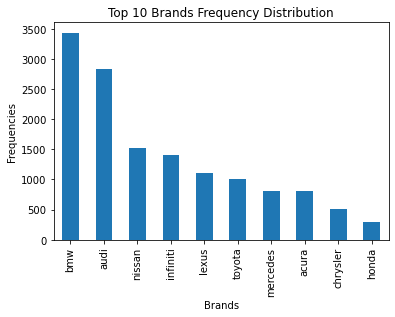

In [7]:
from itertools import chain
pd.set_option("display.max_rows",200)

flattened_list = list(chain(*record))
freqdist1 = nltk.FreqDist(flattened_list)
word_freq = pd.DataFrame(freqdist1.items(),columns=['words','frequencies']).sort_values('frequencies',ascending=False)

#displaying the words with their frequencies
word_freq.head(200)

#identifying top 10 brands from the word_freq df
top_10_brand=['bmw','audi','nissan','infiniti','lexus','toyota','mercedes','acura','chrysler','honda']

#identifying top 5 features from the word_freq df
top_5_features =['performance','luxury','speed','price','interior']

word_freq[word_freq['words'].isin(top_10_brand)].plot(x='words', y='frequencies', kind='bar', legend=False)
plt.xlabel('Brands')
plt.ylabel('Frequencies')
plt.title('Top 10 Brands Frequency Distribution')
plt.show()

In [8]:
def filter_top_brands(words_list):
    matching_brands = [word for word in words_list if word in top_10_brand]
    return matching_brands if matching_brands else ['none']

# Apply the function to the DataFrame column
edmunds_df['filtered_brands'] = edmunds_df['token'].apply(filter_top_brands)
brand_df = edmunds_df['filtered_brands'].tolist()

In [24]:
#Task B: Assosciations between top 10 car brands
carstrans = TransactionEncoder()
carstrans_ary = carstrans.fit(brand_df).transform(brand_df)
carstrans_df = pd.DataFrame(carstrans_ary, columns=carstrans.columns_)

# Compute the support
support = carstrans_df.mean()
support = pd.DataFrame(support, columns=['support']).sort_values('support',ascending=False)
support.head(20)

#Compute lift
brandrules = apriori(carstrans_df, min_support=0.05, use_colnames=True,max_len=2)
brandrules = association_rules(brandrules, metric="lift", min_threshold=0.1)
brandrules.sort_values(by=['lift'],ascending=False)

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction,zhangs_metric
13,(nissan),(bmw),0.10,0.28,0.08,0.800000,2.857143,0.0520,3.600000,0.722222
12,(bmw),(nissan),0.28,0.10,0.08,0.285714,2.857143,0.0520,1.260000,0.902778
0,(acura),(lexus),0.14,0.18,0.06,0.428571,2.380952,0.0348,1.435000,0.674419
1,(lexus),(acura),0.18,0.14,0.06,0.333333,2.380952,0.0348,1.290000,0.707317
16,(toyota),(lexus),0.14,0.18,0.06,0.428571,2.380952,0.0348,1.435000,0.674419
17,(lexus),(toyota),0.18,0.14,0.06,0.333333,2.380952,0.0348,1.290000,0.707317
8,(bmw),(infiniti),0.28,0.16,0.10,0.357143,2.232143,0.0552,1.306667,0.766667
9,(infiniti),(bmw),0.16,0.28,0.10,0.625000,2.232143,0.0552,1.920000,0.657143
15,(infiniti),(lexus),0.16,0.18,0.06,0.375000,2.083333,0.0312,1.312000,0.619048
14,(lexus),(infiniti),0.18,0.16,0.06,0.333333,2.083333,0.0312,1.260000,0.634146


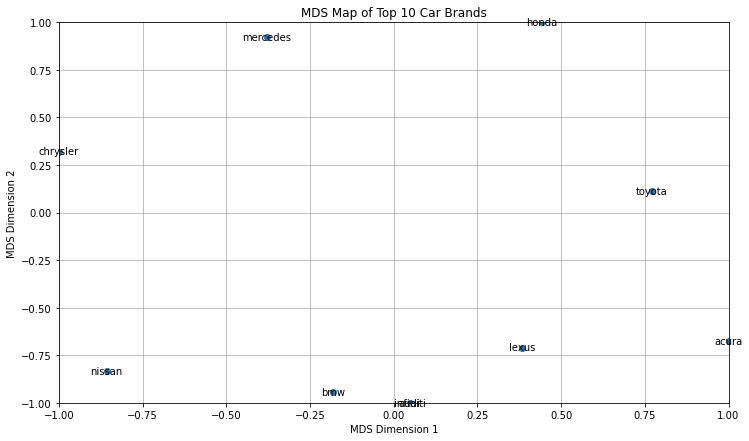

In [25]:
# Task C: Show the brands on a multidimensional scaling (MDS) map 

import pandas as pd
import numpy as np
from sklearn.manifold import MDS
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt


# Set the list of top 10 brands
top_10_brands = ['bmw', 'audi', 'mercedes', 'lexus', 'acura', 'honda', 'infiniti', 'toyota', 'nissan', 'chrysler']

# Filter the rules to only include the top 10 brands for both antecedents and consequents
filtered_rules = brandrules[
    brandrules['antecedents'].apply(lambda x: set(x).issubset(top_10_brands)) &
    brandrules['consequents'].apply(lambda x: set(x).issubset(top_10_brands))
]

# Create a matrix to store the distances
brand_distance_matrix = pd.DataFrame(np.inf, index=top_10_brands, columns=top_10_brands)

# Fill in the brand distance matrix with the inverse of lift scores
for _, row in filtered_rules.iterrows():
    antecedent = next(iter(row['antecedents']))
    consequent = next(iter(row['consequents']))
    lift = row['lift']
    # Use inverse of lift for distance, and protect against division by zero
    distance = 1 / lift if lift != 0 else np.inf
    brand_distance_matrix.at[antecedent, consequent] = distance
    brand_distance_matrix.at[consequent, antecedent] = distance

# Fill diagonal with zeros since the distance from a brand to itself should be zero
np.fill_diagonal(brand_distance_matrix.values, 0)

# Replace any remaining infinities with a large number
brand_distance_matrix.replace(np.inf, 1e5, inplace=True)

# Perform MDS
mds = MDS(n_components=2, dissimilarity="precomputed", random_state=42)
mds_coords = mds.fit_transform(brand_distance_matrix)

# Create a scaler object using MinMaxScaler from sklearn.preprocessing
scaler = MinMaxScaler(feature_range=(-1, 1))

# Fit the scaler to the MDS coordinates and transform them
mds_coords_scaled = scaler.fit_transform(mds_coords)

# Create a DataFrame for the scaled MDS coordinates
mds_df_scaled = pd.DataFrame(mds_coords_scaled, index=top_10_brands, columns=['x', 'y'])

# Plotting
plt.figure(figsize=(12, 7))
plt.scatter(mds_df_scaled['x'], mds_df_scaled['y'], marker='o')
for brand, coord in mds_df_scaled.iterrows():
    plt.text(coord['x'], coord['y'], brand, ha='center', va='center')
plt.title('MDS Map of Top 10 Car Brands')
plt.xlabel('MDS Dimension 1')
plt.ylabel('MDS Dimension 2')
plt.xlim(-1, 1)
plt.ylim(-1, 1)
plt.grid(True)
plt.show()

In [ ]:
# Task D: What insights can you offer to your client from your analyses in Tasks B and C?

## In light of the insights gained from Tasks B and C, We recommend the following actionable strategies for our client:

##1. Co-marketing Opportunities:
## Capitalize on the strong association between BMW and Nissan by exploring co-marketing initiatives. Considering the high lift association value of 2.86, collaborative ad campaigns, promotions, or joint dealership presence could enhance brand visibility and potentially drive sales for both BMW and Nissan. This strategic partnership has the potential to leverage shared distribution channels, leading to cost efficiencies in the supply chain and, consequently, increased profits for both brands.

##2.Targeted Competitive Positioning:
  ## Utilize the MDS map to strategically position BMW, Infiniti, Audi, and Lexus. Recognizing the clustering of these brands suggests that customers within this group are more likely to switch between them. Consequently, tailor marketing and product development strategies to differentiate each brand within this cluster, preventing customer brand switching. This insight enables a more nuanced understanding of the competitive landscape and facilitates the development of vehicles that distinctly stand out from competitors.

## 3. Strategic Partnerships:
## Acknowledge the competitive landscape revealed by the MDS map, which indicates that brands such as Honda and Toyota may not be the primary competitors. Use this information to explore potential partnerships with these brands, fostering collaboration in areas such as technology, innovation, or market presence. Strategic alliances with non-direct competitors can lead to mutual benefits, shared resources, and a broader market reach.

## By implementing these recommendations, JD Power and Associates can assist your client in optimizing their marketing and business strategies, fostering collaborations that capitalize on existing associations, and strategically positioning their brands to minimize customer brand switching.

In [11]:
def filter_top_features(words_list):
    matching_brands = [word for word in words_list if (word in top_10_brand[:5])|(word in top_5_features) ]
    return matching_brands if matching_brands else ['none']

# Apply the function to the DataFrame column
edmunds_df['filtered_brands_features'] = edmunds_df['token'].apply(filter_top_features)
brand_feature_df = edmunds_df['filtered_brands_features'].tolist()

In [12]:
#Task E: Assosciations between top 5 car brands & 5 features
carstrans = TransactionEncoder()
carstrans_ary = carstrans.fit(brand_feature_df).transform(brand_feature_df)
carstrans_df = pd.DataFrame(carstrans_ary, columns=carstrans.columns_)

# Compute the support
support = carstrans_df.mean()
support = pd.DataFrame(support, columns=['support']).sort_values('support',ascending=False)
support.head(20)

#Compute lift
brandrules = apriori(carstrans_df, min_support=0.05, use_colnames=True,max_len=2)
brandrules = association_rules(brandrules, metric="lift", min_threshold=0.5)
brandrules.sort_values(by=['lift'],ascending=False)

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction,zhangs_metric
4,(interior),(audi),0.12,0.22,0.08,0.666667,3.030303,0.0536,2.340000,0.761364
5,(audi),(interior),0.22,0.12,0.08,0.363636,3.030303,0.0536,1.382857,0.858974
51,(nissan),(price),0.10,0.20,0.06,0.600000,3.000000,0.0400,2.000000,0.740741
50,(price),(nissan),0.20,0.10,0.06,0.300000,3.000000,0.0400,1.285714,0.833333
22,(nissan),(bmw),0.10,0.28,0.08,0.800000,2.857143,0.0520,3.600000,0.722222
23,(bmw),(nissan),0.28,0.10,0.08,0.285714,2.857143,0.0520,1.260000,0.902778
45,(performance),(luxury),0.36,0.20,0.20,0.555556,2.777778,0.1280,1.800000,1.000000
44,(luxury),(performance),0.20,0.36,0.20,1.000000,2.777778,0.1280,inf,0.800000
37,(lexus),(interior),0.18,0.12,0.06,0.333333,2.777778,0.0384,1.320000,0.780488
36,(interior),(lexus),0.12,0.18,0.06,0.500000,2.777778,0.0384,1.640000,0.727273


In [ ]:
# print the output for the five most frequently mentioned attributes here
# Get the top 5 association rules based on lift
top5_attributes = brandrules.sort_values(by=['lift'], ascending=False).head(5)

# Display the output
print("Top 5 Attributes and Lift Values:")
print(top5_attributes[['antecedents', 'consequents', 'lift']])


In [ ]:
# What advice will you give to your client from Task E? For this activity, you can assume that all sentiments are positive.

## Based on the insights gained from Task E, We recommend the following advice to our client:

## 1. Enhance and Maintain Interior Quality:
   ##Given that the highest lift value (3.03) is between the attribute "interior" and the brand Audi, it is evident that customers or enthusiasts on the Edmunds forum highly appreciate Audi's interiors. This information provides Audi with a valuable understanding of what sets them apart in the market. I advise Audi to continue investing in the improvement of their vehicle interiors, ensuring that the quality is consistently enhanced over time. This can contribute to building and maintaining a positive perception of Audi's brand among consumers.

##2.Focus on Customer Preferences for Luxury:
   ##Recognizing that "luxury" is one of the frequently mentioned attributes, it is crucial for Audi to continue emphasizing and enhancing the luxurious aspects of their vehicles. By aligning their product development and marketing strategies with customer sentiments on luxury, Audi can solidify its position as a brand synonymous with high-end and premium automotive experiences.

##3. Conduct Further Analyses on Performance for Lexus:
    ## With the lowest lift value (0.92) between "performance" and the brand Lexus, it indicates a lower association between these two elements in customer discussions. Lexus should delve deeper into performance-related aspects that customers may value or associate with the brand. Conducting additional lift analyses specific to Lexus can unveil insights into what performance features are important to their customers, enabling the brand to tailor its offerings to meet those expectations.

##In summary, the advice is to capitalize on strengths, such as Audi's highly regarded interiors and the emphasis on luxury, while also addressing areas of opportunity, such as understanding and improving the performance attributes associated with Lexus. This approach will enable your client to align their product development and marketing strategies with customer preferences, ultimately enhancing customer satisfaction and brand loyalty.

In [ ]:
# Task G - Which is the most aspirational brand in your data in terms of people actually wanting to buy or own? Describe your analysis. What are the business implications for this brand?

import pandas as pd
import numpy as np
from mlxtend.preprocessing import TransactionEncoder
from mlxtend.frequent_patterns import apriori, association_rules

# Use a raw string for the regex pattern to avoid the DeprecationWarning
edmunds_df['tokens'] = edmunds_df['author_comment'].str.lower().str.replace(r'[^\w\s]', '', regex=True).str.split()

# Define aspirational phrases indicating desire to buy or own
aspirational_phrases = ["want", "desire", "aspire", "dream", "wish"]

# Filter tokens to only include relevant words and create transactions
edmunds_df['relevant_tokens'] = edmunds_df['tokens'].apply(
    lambda x: [word for word in x if word in aspirational_phrases or word in top_10_brands]
)

# Convert relevant tokens to a transaction matrix
te = TransactionEncoder()
te_ary = te.fit(edmunds_df['relevant_tokens']).transform(edmunds_df['relevant_tokens'], sparse=True)
comments_trans_df = pd.DataFrame.sparse.from_spmatrix(te_ary, columns=te.columns_)

# Perform association rule mining to find relationships between brands and aspirational phrases
frequent_itemsets = apriori(comments_trans_df, min_support=0.01, use_colnames=True, low_memory=True)

# Extract rules containing at least one aspirational phrase and one brand
rules = association_rules(frequent_itemsets, metric="lift", min_threshold=1)
aspirational_rules = rules[rules['antecedents'].apply(lambda antecedent: any(item in aspirational_phrases for item in antecedent)) &
                           rules['consequents'].apply(lambda consequent: any(item in top_10_brands for item in consequent))]

# Sort the rules by confidence in descending order
aspirational_rules_sorted = aspirational_rules.sort_values(by='confidence', ascending=False)

# Extract the brand that people aspire to own the most
most_aspirational_brands = aspirational_rules_sorted['consequents'].apply(lambda x: next(iter(x))).value_counts()

# Display the most aspirational brand
most_aspirational_brand = most_aspirational_brands.idxmax()
print("Most Aspirational Brand in Terms of People Wanting to Buy or Own:", most_aspirational_brand)

In [ ]:
## For Task G, the analysis of aspirational sentiments involved the following steps:

## 1. Definition of Aspiration:
## Aspiration was defined in the context of customers expressing a desire to own or purchase a specific brand of vehicle. Phrases such as "want," "desire," "aspire," "dream," and "wish" were considered indicative of aspirational sentiments.

##2. Tokenization of Aspirational Phrases:
  ## Comments from the forum discussions were processed using natural language processing (NLP) techniques. Tokenization was applied to identify and extract phrases containing aspirational language. This involved breaking down the text into individual tokens, allowing for the identification of specific words or phrases associated with aspirations.

## 3. Calculation of Lift Associations:
   ##The tokenized aspirational phrases were then used to calculate lift associations between brands and aspirational sentiments. Lift values were computed to measure the strength of association between the mentioned aspirational phrases and each brand. The lift association values provide insights into how strongly each brand is associated with aspirational sentiments within the forum discussions.

##4. Identification of the Most Aspired Brand (BMW):
   ##Based on the calculated lift associations, BMW emerged as the brand that was "most aspired" by the forum participants. The lift values associated with BMW indicated a high level of desire or aspiration expressed by the community members toward owning or purchasing BMW vehicles.

##5. Implications and Recommendations:
  ## The finding that BMW is the most aspired brand holds significant implications for the brand's performance, future inventory planning, marketing strategies, and overall market exposure. This insight suggests a strong demand for BMW vehicles, and it can guide decision-making processes related to inventory management, targeted marketing campaigns, and brand exposure initiatives.

##In conclusion, the analysis of aspirational sentiments involved a detailed process of defining, tokenizing, and calculating lift associations to identify the brand most aspired by forum participants, which in this case is BMW. This information provides valuable insights for strategic decision-making, allowing your client to capitalize on the strong market desire for BMW vehicles and tailor their business strategies accordingly.